## Panorama stitching

One of the scikit-image tutorials shows [how to do panorama stitching](https://github.com/scikit-image/skimage-tutorials/blob/master/lectures/solutions/adv3_panorama-stitching-solution.ipynb).

Take 3 or 4 overlapping photos of your own, and use the procedure described to stitch your own panorama.

In [3]:
###
# Cloned from tutorial on github: https://github.com/scikit-image/skimage-tutorials/blob/master/lectures/solutions/adv3_panorama-stitching-solution.ipynb
# With small modifications for my specific images
# Works pretty well! It seems that two of my images had slightly different lighting and this made the stitch a little less than perfect, but still quite good
# Also seems like the algorithm on github does not seek to find the maximal stitched image when it computes the least cost path
# For images like mine with slightly different lightings this leads it to choose "optimal" paths that in fact cut off large parts of the images
# I think this could be fixed by re-weighting the costs such that there is a high penalty for passing through the \emph{non}-overlapping parts of the two images
# Output is stored in pano-advanced-output.png
###

from __future__ import division, print_function
%matplotlib inline

# scikit-image advanced panorama tutorial

Enhanced from the original demo as featured in [the scikit-image paper](https://peerj.com/articles/453/).

Multiple overlapping images of the same scene, combined into a single image, can yield amazing results. This tutorial will illustrate how to accomplish panorama stitching using scikit-image, from loading the images to cleverly stitching them together.

### First things first

Import NumPy and matplotlib, then define a utility function to compare multiple images

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def compare(*images, **kwargs):
    """
    Utility function to display images side by side.
    
    Parameters
    ----------
    image0, image1, image2, ... : ndarrray
        Images to display.
    labels : list
        Labels for the different images.
    """
    f, axes = plt.subplots(1, len(images), **kwargs)
    axes = np.array(axes, ndmin=1)
    
    labels = kwargs.pop('labels', None)
    if labels is None:
        labels = [''] * len(images)
    
    for n, (image, label) in enumerate(zip(images, labels)):
        axes[n].imshow(image, interpolation='nearest', cmap='gray')
        axes[n].set_title(label)
        axes[n].axis('off')
    
    f.tight_layout()

### Load data

The ``ImageCollection`` class provides an easy and efficient way to load and represent multiple images. Images in the ``ImageCollection`` are not only read from disk when accessed.

Load a series of images into an ``ImageCollection`` with a wildcard, as they share similar names. 

In [5]:
import skimage.io as io

#load three images
filenames = ["img%i.JPG" % i for i in range(3)]
pano_imgs = [io.imread(fn) for fn in filenames]


Inspect these images using the convenience function `compare()` defined earlier

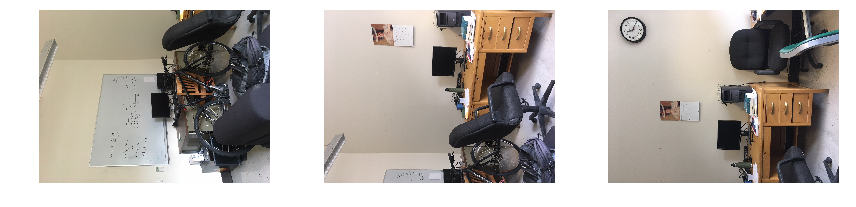

In [6]:
compare(*pano_imgs, figsize=(12, 10))

Credit: Images of Private Arch and the trail to Delicate Arch in Arches National Park, USA, taken by Joshua D. Warner.<br>
License: CC-BY 4.0

---

# 0. Pre-processing

This stage usually involves one or more of the following:
* Resizing, often downscaling with fixed aspect ratio
* Conversion to grayscale, as many feature descriptors are not defined for color images
* Cropping to region(s) of interest

For convenience our example data is already resized smaller, and we won't bother cropping. However, they are presently in color so coversion to grayscale with `skimage.color.rgb2gray` is appropriate.

In [7]:
from skimage.color import rgb2gray

pano0, pano1, pano2 = [rgb2gray(im) for im in pano_imgs]

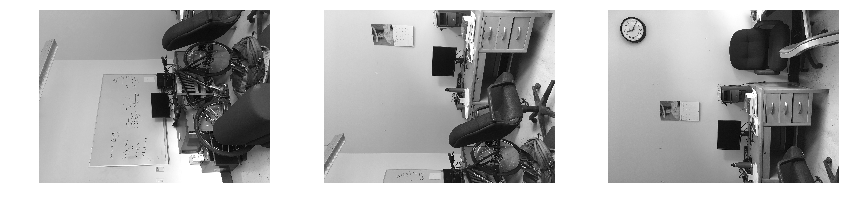

In [8]:
# View the results
compare(pano0, pano1, pano2, figsize=(12, 10))

# 1. Feature detection and matching

We need to estimate a projective transformation that relates these images together. The steps will be

1. Define one image as a _target_ or _destination_ image, which will remain anchored while the others are warped
2. Detect features in all three images
3. Match features from left and right images against the features in the center, anchored image.

In this three-shot series, the middle image `pano1` is the logical anchor point.

We detect "Oriented FAST and rotated BRIEF" (ORB) features in both images. 

**Note:** For efficiency, in this tutorial we're finding 800 keypoints. The results are good but small variations are expected. If you need a more robust estimate in practice, run multiple times and pick the best result _or_ generate additional keypoints.

In [9]:
from skimage.feature import ORB

# Initialize ORB
# 800 keypoints is large enough for robust results, 
# but low enough to run within a few seconds. 
orb = ORB(n_keypoints=1500, fast_threshold=0.05)

# Detect keypoints in pano0
orb.detect_and_extract(pano0)
keypoints0 = orb.keypoints
descriptors0 = orb.descriptors

# Detect keypoints in pano1
orb.detect_and_extract(pano1)
keypoints1 = orb.keypoints
descriptors1 = orb.descriptors

# Detect keypoints in pano2
orb.detect_and_extract(pano2)
keypoints2 = orb.keypoints
descriptors2 = orb.descriptors

Match features from images 0 <-> 1 and 1 <-> 2.

In [10]:
from skimage.feature import match_descriptors

# Match descriptors between left/right images and the center
matches01 = match_descriptors(descriptors0, descriptors1, cross_check=True)
matches12 = match_descriptors(descriptors1, descriptors2, cross_check=True)

Inspect these matched features side-by-side using the convenience function ``skimage.feature.plot_matches``. 

Most of these line up similarly, but it isn't perfect. There are a number of obvious outliers or false matches.

Similar to above, decent signal but numerous false matches.

---

# 2. Transform estimation

To filter out the false matches, we apply RANdom SAmple Consensus (RANSAC), a powerful method of rejecting outliers available in ``skimage.transform.ransac``.  The transformation is estimated iteratively, based on randomly chosen subsets, finally selecting the model which corresponds best with the majority of matches.

We need to do this twice, once each for the transforms left -> center and right -> center.

In [11]:
from skimage.transform import ProjectiveTransform
from skimage.measure import ransac

# Select keypoints from 
#   * source (image to be registered): pano0
#   * target (reference image): pano1, our middle frame registration target
src = keypoints0[matches01[:, 0]][:, ::-1]
dst = keypoints1[matches01[:, 1]][:, ::-1]

model_robust01, inliers01 = ransac((src, dst), ProjectiveTransform,
                                   min_samples=4, residual_threshold=1, max_trials=300)

# Select keypoints from 
#   * source (image to be registered): pano2
#   * target (reference image): pano1, our middle frame registration target
src = keypoints2[matches12[:, 1]][:, ::-1]
dst = keypoints1[matches12[:, 0]][:, ::-1]

model_robust12, inliers12 = ransac((src, dst), ProjectiveTransform,
                                   min_samples=4, residual_threshold=1, max_trials=300)

The `inliers` returned from RANSAC select the best subset of matches. How do they look?

Most of the false matches are rejected!

---

# 3. Warping

Next, we produce the panorama itself. We must _warp_, or transform, two of the three images so they will properly align with the stationary image.

### Extent of output image
The first step is to find the shape of the output image to contain all three transformed images. To do this we consider the extents of all warped images.

In [12]:
from skimage.transform import SimilarityTransform

# Shape of middle image, our registration target
r, c = pano1.shape[:2]

# Note that transformations take coordinates in (x, y) format,
# not (row, column), in order to be consistent with most literature
corners = np.array([[0, 0],
                    [0, r],
                    [c, 0],
                    [c, r]])

# Warp the image corners to their new positions
warped_corners01 = model_robust01(corners)
warped_corners12 = model_robust12(corners)

# Find the extents of both the reference image and the warped
# target image
all_corners = np.vstack((warped_corners01, warped_corners12, corners))

# The overall output shape will be max - min
corner_min = np.min(all_corners, axis=0)
corner_max = np.max(all_corners, axis=0)
output_shape = (corner_max - corner_min)

# Ensure integer shape with np.ceil and dtype conversion
output_shape = np.ceil(output_shape[::-1]).astype(int)

### Apply estimated transforms

Warp the images with `skimage.transform.warp` according to the estimated models. A shift, or _translation_ is needed to place as our middle image in the middle - it isn't truly stationary.

Values outside the input images are initially set to -1 to distinguish the "background", which is identified for later use.

**Note:** ``warp`` takes the _inverse_ mapping as an input.

In [13]:
from skimage.transform import warp

# This in-plane offset is the only necessary transformation for the middle image
offset1 = SimilarityTransform(translation= -corner_min)

# Translate pano1 into place
pano1_warped = warp(pano1, offset1.inverse, order=3,
                    output_shape=output_shape, cval=-1)

# Acquire the image mask for later use
pano1_mask = (pano1_warped != -1)  # Mask == 1 inside image
pano1_warped[~pano1_mask] = 0      # Return background values to 0

Warp left panel into place

In [14]:
# Warp pano0 (left) to pano1
transform01 = (model_robust01 + offset1).inverse
pano0_warped = warp(pano0, transform01, order=3,
                    output_shape=output_shape, cval=-1)

pano0_mask = (pano0_warped != -1)  # Mask == 1 inside image
pano0_warped[~pano0_mask] = 0      # Return background values to 0

Warp right panel into place

In [15]:
# Warp pano2 (right) to pano1 
transform12 = (model_robust12 + offset1).inverse
pano2_warped = warp(pano2, transform12, order=3,
                    output_shape=output_shape, cval=-1)

pano2_mask = (pano2_warped != -1)  # Mask == 1 inside image
pano2_warped[~pano2_mask] = 0      # Return background values to 0

Inspect the warped images:

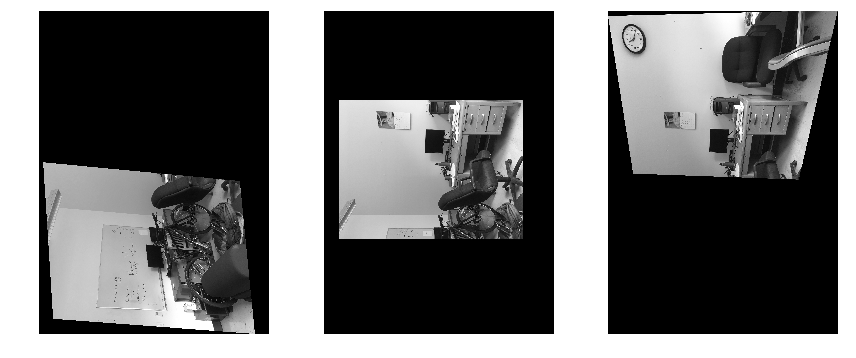

In [16]:
compare(pano0_warped, pano1_warped, pano2_warped, figsize=(12, 10));

---

# 4. Combining images the easy (and bad) way

This method simply 

1. sums the warped images
2. tracks how many images overlapped to create each  point
3. normalizes the result.

In [17]:
# Add the three images together. This could create dtype overflows!
# We know they are are floating point images after warping, so it's OK.
merged = (pano0_warped + pano1_warped + pano2_warped)

In [18]:
# Track the overlap by adding the masks together
overlap = (pano0_mask * 1.0 +  # Multiply by 1.0 for bool -> float conversion
           pano1_mask + 
           pano2_mask)

In [19]:
# Normalize through division by `overlap` - but ensure the minimum is 1
normalized = merged / np.maximum(overlap, 1)

Finally, view the results!

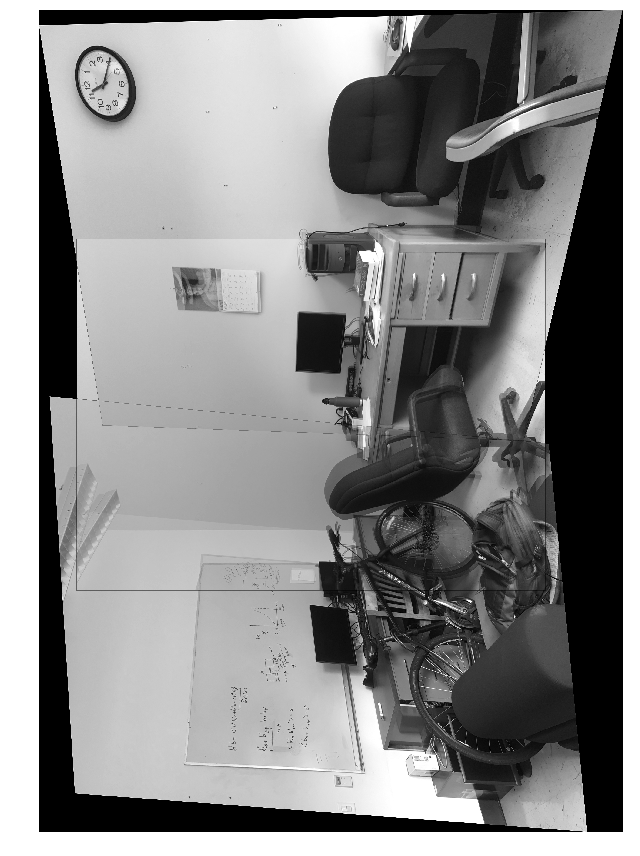

In [20]:
fig, ax = plt.subplots(figsize=(12, 12))

ax.imshow(normalized, cmap='gray')

plt.tight_layout()
ax.axis('off');

**What happened?!** Why are there nasty dark lines at boundaries, and why does the middle look so blurry?


The **lines are artifacts (boundary effect) from the warping method**. When the image is warped with interpolation, edge pixels containing part image and part background combine these values. We would have bright lines if we'd chosen `cval=2` in the `warp` calls (try it!), but regardless of choice there will always be discontinuities.

...Unless you use `order=0` in `warp`, which is nearest neighbor. Then edges are perfect (try it!). But who wants to be limited to an inferior interpolation method? 

Even then, it's blurry! Is there a better way?

---

# 5. Stitching images along a minimum-cost path

Let's step back a moment and consider: Is it even reasonable to blend pixels?

Take a look at a difference image, which is just one image subtracted from the other.

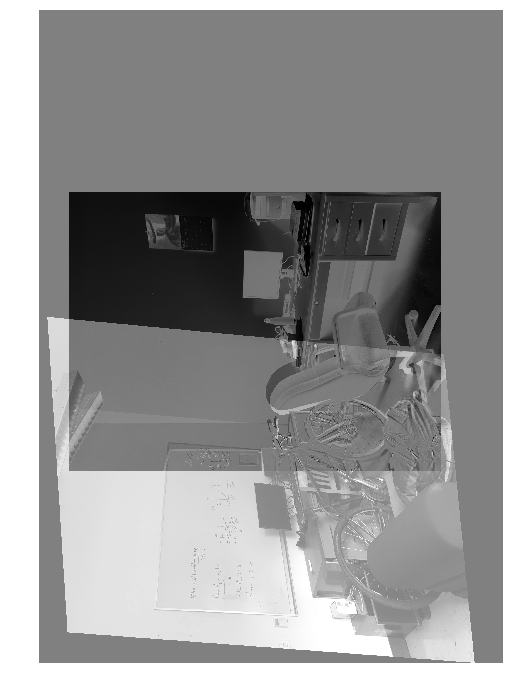

In [21]:
fig, ax = plt.subplots(figsize=(15,12))

# Generate difference image and inspect it
difference_image = pano0_warped - pano1_warped
ax.imshow(difference_image, cmap='gray')

ax.axis('off');

The surrounding flat gray is zero. _A perfect overlap would show no structure!_ 

Instead, the overlap region matches fairly well in the middle... but off to the sides where things start to look a little embossed, a simple average blurs the result. This caused the blurring in the previous, method (look again). _Unfortunately, this is almost always the case for panoramas!_

How can we fix this?

Let's attempt to find a vertical path through this difference image which stays as close to zero as possible. If we use that to build a mask, defining a transition between images, the result should appear _seamless_.

---

# Seamless image stitching with Minimum-Cost Paths and `skimage.graph`

Among other things, `skimage.graph` allows you to
* start at any point on an array
* find the path to any other point in the array
* the path found _minimizes_ the sum of values on the path.


The array is called a _cost array_, while the path found is a _minimum-cost path_ or **MCP**.

To accomplish this we need

* Starting and ending points for the path
* A cost array (a modified difference image)

This method is so powerful that, with a carefully constructed cost array, the seed points are essentially irrelevant. It just works!

### Define seed points

In [22]:
ymax = output_shape[1] - 1
xmax = output_shape[0] - 1

# Start anywhere along the top and bottom, left of center.
mask_pts01 = [[0,    2*ymax // 3],
              [xmax, 2*ymax // 3]]

# Start anywhere along the top and bottom, right of center.
mask_pts12 = [[0,    2*ymax // 3],
              [xmax, 2*ymax // 3]]

### Construct cost array

This utility function exists to give a "cost break" for paths from the edge to the overlap region.

We will visually explore the results shortly. Examine the code later - for now, just use it.

In [23]:
from skimage.measure import label

def generate_costs(diff_image, mask, vertical=True, gradient_cutoff=2.):
    """
    Ensures equal-cost paths from edges to region of interest.
    
    Parameters
    ----------
    diff_image : ndarray of floats
        Difference of two overlapping images.
    mask : ndarray of bools
        Mask representing the region of interest in ``diff_image``.
    vertical : bool
        Control operation orientation.
    gradient_cutoff : float
        Controls how far out of parallel lines can be to edges before
        correction is terminated. The default (2.) is good for most cases.
        
    Returns
    -------
    costs_arr : ndarray of floats
        Adjusted costs array, ready for use.
    """
    if vertical is not True:
        return tweak_costs(diff_image.T, mask.T, vertical=vertical,
                           gradient_cutoff=gradient_cutoff).T
    
    # Start with a high-cost array of 1's
    costs_arr = np.ones_like(diff_image)
    
    # Obtain extent of overlap
    row, col = mask.nonzero()
    cmin = col.min()
    cmax = col.max()

    # Label discrete regions
    cslice = slice(cmin, cmax + 1)
    labels = label(mask[:, cslice])
    
    # Find distance from edge to region
    upper = (labels == 0).sum(axis=0)
    lower = (labels == 2).sum(axis=0)
    
    # Reject areas of high change
    ugood = np.abs(np.gradient(upper)) < gradient_cutoff
    lgood = np.abs(np.gradient(lower)) < gradient_cutoff
    
    # Give areas slightly farther from edge a cost break
    costs_upper = np.ones_like(upper, dtype=np.float64)
    costs_lower = np.ones_like(lower, dtype=np.float64)
    costs_upper[ugood] = upper.min() / np.maximum(upper[ugood], 1)
    costs_lower[lgood] = lower.min() / np.maximum(lower[lgood], 1)
    
    # Expand from 1d back to 2d
    vdist = mask.shape[0]
    costs_upper = costs_upper[np.newaxis, :].repeat(vdist, axis=0)
    costs_lower = costs_lower[np.newaxis, :].repeat(vdist, axis=0)
    
    # Place these in output array
    costs_arr[:, cslice] = costs_upper * (labels == 0)
    costs_arr[:, cslice] +=  costs_lower * (labels == 2)
    
    # Finally, place the difference image
    costs_arr[mask] = diff_image[mask]
    
    return costs_arr

Use this function to generate the cost array.

In [24]:
# Start with the absolute value of the difference image.
# np.abs is necessary because we don't want negative costs!
costs01 = generate_costs(np.abs(pano0_warped - pano1_warped),
                         pano0_mask & pano1_mask)

Allow the path to "slide" along top and bottom edges to the optimal horizontal position by setting top and bottom edges to zero cost.

In [25]:
costs01[0,  :] = 0
costs01[-1, :] = 0

Our cost array now looks like this

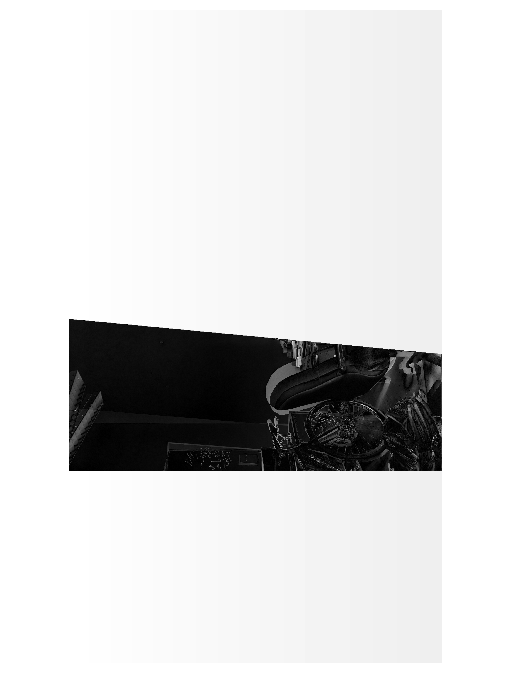

In [26]:
fig, ax = plt.subplots(figsize=(15, 12))

ax.imshow(costs01, cmap='gray', interpolation='none')

ax.axis('off');

The tweak we made with `generate_costs` is subtle but important. Can you see it?

### Find the minimum-cost path (MCP)

Use `skimage.graph.route_through_array` to find an optimal path through the cost array

In [27]:
from skimage.graph import route_through_array

# Arguments are:
#   cost array
#   start pt
#   end pt
#   can it traverse diagonally
pts, _ = route_through_array(costs01, mask_pts01[0], mask_pts01[1], fully_connected=True)

# Convert list of lists to 2d coordinate array for easier indexing
pts = np.array(pts)

Did it work?

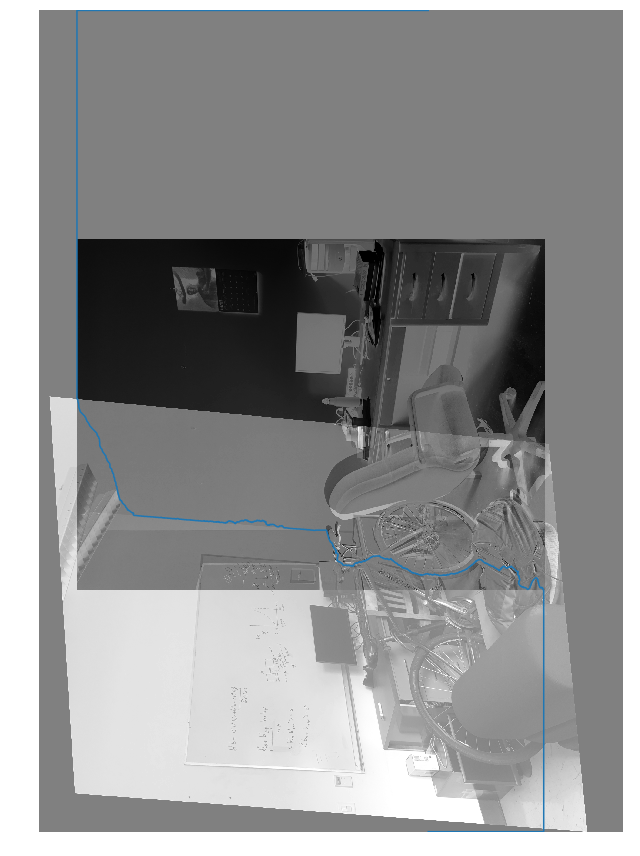

In [28]:
fig, ax = plt.subplots(figsize=(12, 12))

# Plot the difference image
ax.imshow(pano0_warped - pano1_warped, cmap='gray')

# Overlay the minimum-cost path
ax.plot(pts[:, 1], pts[:, 0])  

plt.tight_layout()
ax.axis('off');

That looks like a great seam to stitch these images together - the path looks very close to zero.

### Irregularities

Due to the random element in the RANSAC transform estimation, everyone will have a slightly different path. **Your path will look different from mine, and different from your neighbor's.** That's expected! _The awesome thing about MCP is that everyone just calculated the best possible path to stitch together their unique transforms!_

### Filling the mask

Turn that path into a mask, which will be 1 where we want the left image to show through and zero elsewhere. We need to fill the left side of the mask with ones over to our path.

**Note**: This is the inverse of NumPy masked array conventions (``numpy.ma``), which specify a negative mask (mask == bad/missing) rather than a positive mask as used here (mask == good/selected).

Place the path into a new, empty array.

In [29]:
# Start with an array of zeros and place the path
mask0 = np.zeros_like(pano0_warped, dtype=np.uint8)
mask0[pts[:, 0], pts[:, 1]] = 1

Ensure the path appears as expected

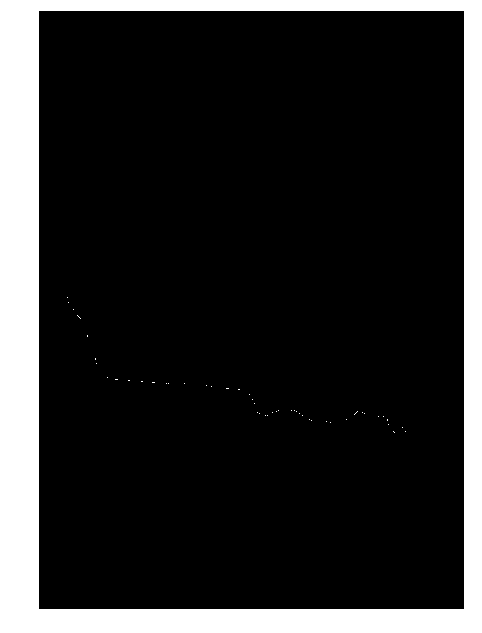

In [30]:
fig, ax = plt.subplots(figsize=(11, 11))

# View the path in black and white
ax.imshow(mask0, cmap='gray')

ax.axis('off');

Label the various contiguous regions in the image using `skimage.measure.label`

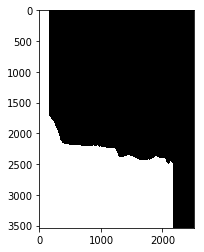

In [31]:
from skimage.measure import label

# Labeling starts with one at point (0, 0)
mask0 = (label(mask0, connectivity=1, background=-1) == 1)
#mask0 = np.logical_or(~np.ceil(pano1_warped).astype(bool),mask0)

# The result
plt.imshow(mask0, cmap='gray');

Looks great!

### Rinse and repeat

Apply the same principles to images 1 and 2: first, build the cost array

In [32]:
# Start with the absolute value of the difference image.
# np.abs necessary because we don't want negative costs!
costs12 = generate_costs(np.abs(pano1_warped - pano2_warped),
                         pano1_mask & pano2_mask)

# Allow the path to "slide" along top and bottom edges to the optimal 
# horizontal position by setting top and bottom edges to zero cost
costs12[0,  :] = 0
costs12[-1, :] = 0

**Add an additional constraint this time**, to prevent this path crossing the prior one!

In [33]:
costs12[mask0 > 0] = 1

Check the result

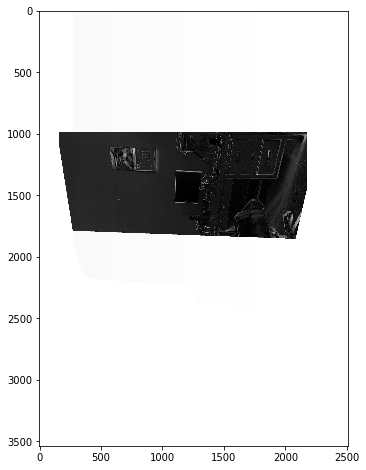

In [34]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(costs12, cmap='gray');

Your results may look slightly different.

Compute the minimal cost path

In [35]:
# Arguments are:
#   cost array
#   start pt
#   end pt
#   can it traverse diagonally
pts, _ = route_through_array(costs12, mask_pts12[0], mask_pts12[1], fully_connected=True)

# Convert list of lists to 2d coordinate array for easier indexing
pts = np.array(pts)

Verify a reasonable result

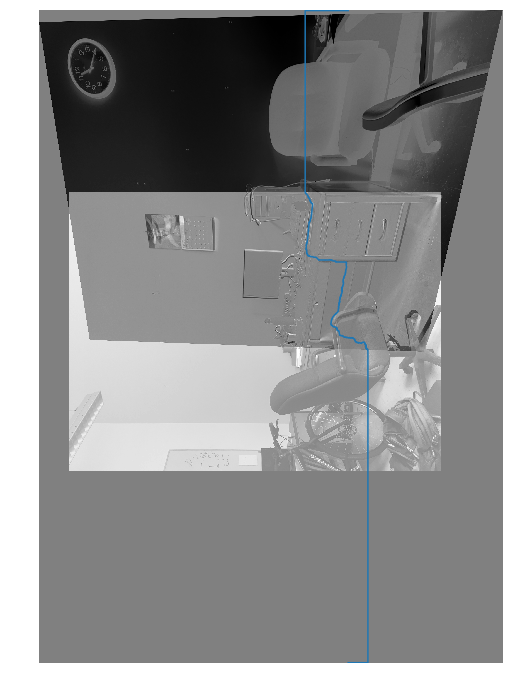

In [36]:
fig, ax = plt.subplots(figsize=(12, 12))

# Plot the difference image
ax.imshow(pano1_warped - pano2_warped, cmap='gray')

# Overlay the minimum-cost path
ax.plot(pts[:, 1], pts[:, 0]);

ax.axis('off');

Initialize the mask by placing the path in a new array

In [39]:
mask2 = np.zeros_like(pano0_warped, dtype=np.uint8)
mask2[pts[:, 0], pts[:, 1]] = 1

Fill the right side this time, again using `skimage.measure.label` - the label of interest is 2

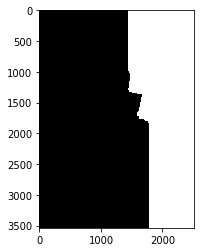

In [40]:
mask2 = (label(mask2, connectivity=1, background=-1) == 3)

#mask2 = (~np.ceil(pano1_warped).astype(bool) | mask2).astype(bool)

# The result
plt.imshow(mask2, cmap='gray');

### Final mask

The last mask for the middle image is one of exclusion - it will be displayed everywhere `mask0` and `mask2` are not.

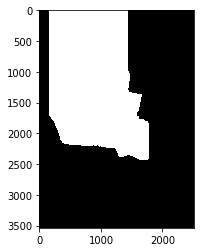

In [41]:
mask1 = ~(mask0 | mask2).astype(bool)
plt.imshow(mask1, cmap='gray');

Define a convenience function to place masks in alpha channels

In [42]:
def add_alpha(img, mask=None):
    """
    Adds a masked alpha channel to an image.
    
    Parameters
    ----------
    img : (M, N[, 3]) ndarray
        Image data, should be rank-2 or rank-3 with RGB channels
    mask : (M, N[, 3]) ndarray, optional
        Mask to be applied. If None, the alpha channel is added
        with full opacity assumed (1) at all locations.
    """
    from skimage.color import gray2rgb
    if mask is None:
        mask = np.ones_like(img)
        
    if img.ndim == 2:
        img = gray2rgb(img)
    
    return np.dstack((img, mask))

Obtain final, alpha blended individual images and inspect them

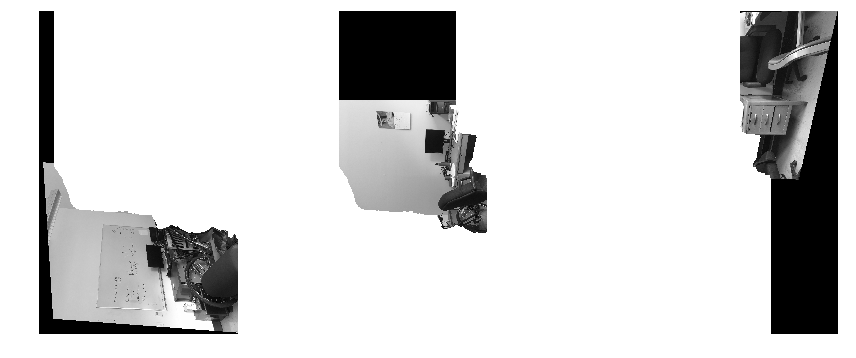

In [43]:
pano0_final = add_alpha(pano0_warped, mask0)
pano1_final = add_alpha(pano1_warped, mask1)
pano2_final = add_alpha(pano2_warped, mask2)

compare(pano0_final, pano1_final, pano2_final, figsize=(12, 12))

What we have here is the world's most complicated and precisely-fitting jigsaw puzzle...

Plot all three together and view the results!

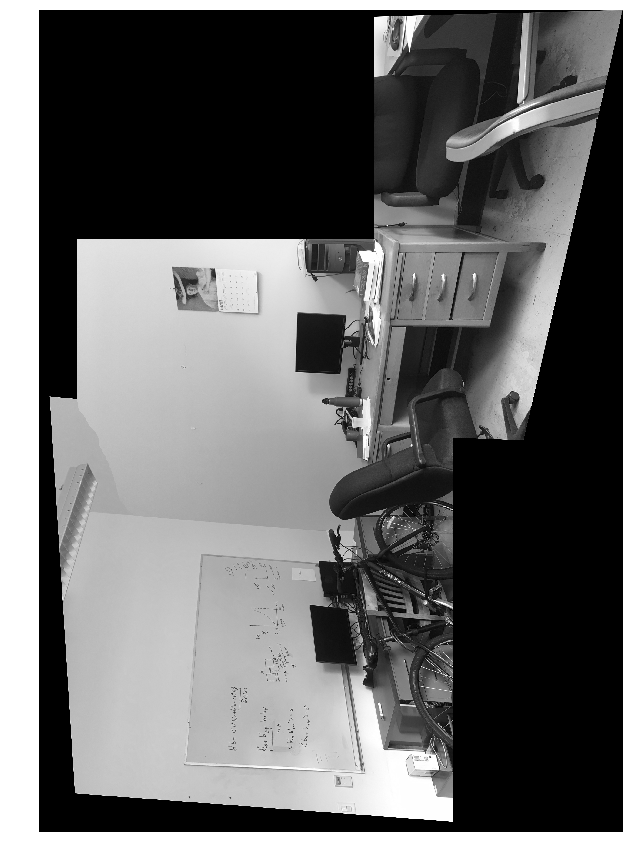

In [44]:
fig, ax = plt.subplots(figsize=(12, 12))

# This is a perfect combination, but matplotlib's interpolation
# makes it appear to have gaps. So we turn it off.
ax.imshow(pano0_final, interpolation='none')
ax.imshow(pano1_final, interpolation='none')
ax.imshow(pano2_final, interpolation='none')

fig.tight_layout()
ax.axis('off');

Fantastic! Without the black borders, you'd never know this was composed of separate images!

---

# Bonus round: now, in color!

We converted to grayscale for ORB feature detection, back in the initial **preprocessing** steps. Since we stored our transforms and masks, adding color is straightforward!

Transform the colored images

In [45]:
# Identical transforms as before, except
#   * Operating on original color images
#   * filling with cval=0 as we know the masks
pano0_color = warp(pano_imgs[0], (model_robust01 + offset1).inverse, order=3,
                   output_shape=output_shape, cval=0)

pano1_color = warp(pano_imgs[1], offset1.inverse, order=3,
                   output_shape=output_shape, cval=0)

pano2_color = warp(pano_imgs[2], (model_robust12 + offset1).inverse, order=3,
                   output_shape=output_shape, cval=0)

Then apply the custom alpha channel masks

In [46]:
pano0_final = add_alpha(pano0_color, mask0)
pano1_final = add_alpha(pano1_color, mask1)
pano2_final = add_alpha(pano2_color, mask2)

View the result!

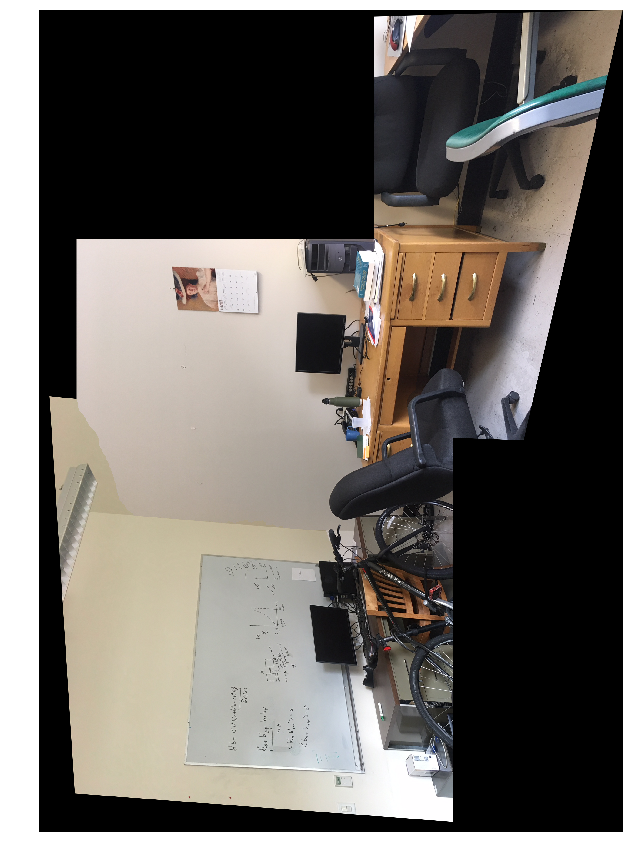

In [47]:
fig, ax = plt.subplots(figsize=(12, 12))

# Turn off matplotlib's interpolation
ax.imshow(pano0_final, interpolation='none')
ax.imshow(pano1_final, interpolation='none')
ax.imshow(pano2_final, interpolation='none')

fig.tight_layout()
ax.axis('off');

Save the combined, color panorama locally as `'./pano-advanced-output.png'`

In [48]:
from skimage.color import gray2rgb

# Start with empty image
pano_combined = np.zeros_like(pano0_color)

# Place the masked portion of each image into the array
# masks are 2d, they need to be (M, N, 3) to match the color images
pano_combined += pano0_color * gray2rgb(mask0)
pano_combined += pano1_color * gray2rgb(mask1)
pano_combined += pano2_color * gray2rgb(mask2)


# Save the output - precision loss warning is expected
# moving from floating point -> uint8
io.imsave('./pano-advanced-output.png', pano_combined)

/Users/Tommy/anaconda2/envs/py36/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
